In [1]:
import os
import torchvision
from torchvision import transforms
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib
from matplotlib import pyplot as plt
import zipfile
from tqdm import tqdm
from PIL import Image
import random

#Data preproceccing

In [2]:
path = '../input/stmimage'
path1 = '../input/yasuo-dataset/Double tip image recognition/double tip recognition'

train_dir = path + '/Train'
test_dir = path + '/Test'

train_dir1 = path1 + '/Train'
test_dir1 = path1 + '/Test'

transform = torchvision.transforms.Compose([   
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),    
    torchvision.transforms.RandomAffine(90, translate=None, scale=None, shear=None, resample=False, fillcolor=0),
    transforms.ToTensor(),                  
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                                    
                                          ])


train_dataset = torchvision.datasets.ImageFolder(train_dir, transform = transform)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform = transform)


train_dataset1 = torchvision.datasets.ImageFolder(train_dir1, transform = transform)
test_dataset1 = torchvision.datasets.ImageFolder(test_dir1, transform = transform)

#Preparing batches

In [3]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True, drop_last = True)

train_loader1 = torch.utils.data.DataLoader(train_dataset1, batch_size=5, shuffle=True, drop_last = True)
test_loader1 = torch.utils.data.DataLoader(test_dataset1, batch_size=5, shuffle=True, drop_last = True)

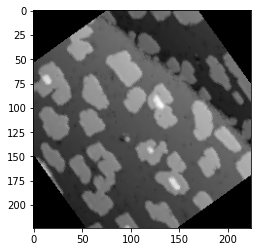

1





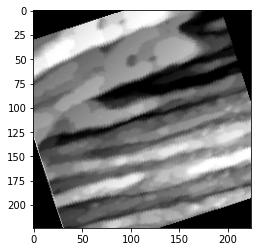

0





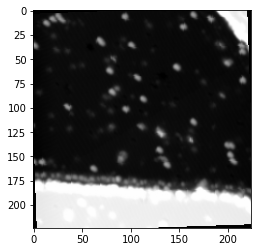

0





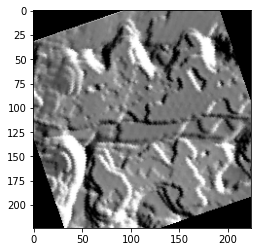

1





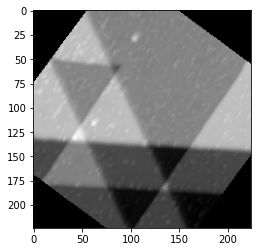

1





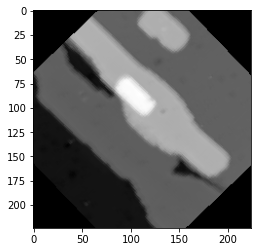

0





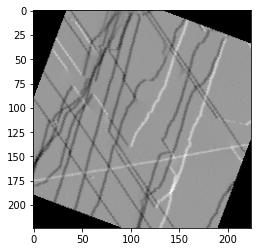

1





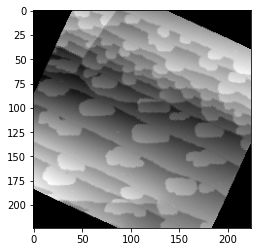

1





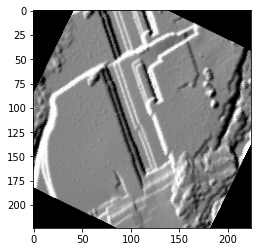

0





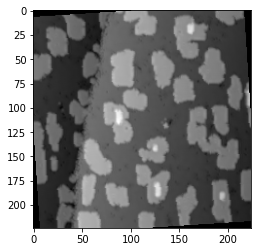

1





In [4]:
def watch_pics(dataset, n=10):
    l = len(dataset)
    for i in range(n):
        r = random.randint(0,l-1)
        data = dataset[r][0]
        data = (data - data.min())/(data.max()-data.min())
        label = dataset[r][1]
        data = data.permute(1,2,0)
        plt.imshow(data)
        plt.show()
        print(str(label)+"\n\n\n")
    return 


watch_pics(train_dataset1)

#Train-Test procedures

In [5]:
def train_model(model, loss, optimizer, scheduler, num_epochs, train_loader, test_loader):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            true_negative = 0
            true_positive = 0
            false_negative = 0
            false_positive = 0
            if phase == 'train':
                dataloader = train_loader
                model.train()  # Set model to training mode
            else:
                dataloader = test_loader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    for i, single_pred in enumerate(preds_class):
                        if single_pred< 0.5:
                            if labels[i]<0.5:
                                true_negative += 1
                                
                            else:
                                false_negative += 1
                                
                        else:
                            if labels[i]<0.5:
                                false_positive += 1
                                
                            else:
                                true_positive += 1
                                

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                scheduler.step()
            
            if true_negative + false_negative ==0:
                precision0 =0. 
            else:
                precision0 = true_negative / (true_negative + false_negative)
            if true_positive + false_positive ==0:
                precision1 = 0.
            else:
                precision1 = true_positive / (true_positive + false_positive)
            recall0 = true_negative / (true_negative + false_positive)
            recall1 = true_positive / (true_positive + false_negative)
            print(' {} Loss: {:.4f} Acc: {:.4f} \n recall0: {:.4f}    recall1: {:.4f} \n precision0: {:.4f}    precision1: {:.4f} \n\n'.format(phase, epoch_loss, epoch_acc, recall0, recall1, precision0, precision1), flush=True)

    return model

In [64]:
def test_model(model, loss, test_loader):
    true_negative = 0
    true_positive = 0
    false_negative = 0
    false_positive = 0

    dataloader = test_loader
    model.eval()   # Set model to evaluate mode

    running_loss = 0.
    running_acc = 0.

    # Iterate over data.
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

             

    
        with torch.set_grad_enabled(False):
            preds = model(inputs)
            loss_value = loss(preds, labels)
            preds_class = preds.argmax(dim=1)

            for i, single_pred in enumerate(preds_class):
                if single_pred< 0.5:
                    if labels[i]<0.5:
                        true_negative += 1
                    else:
                        false_negative += 1
                                
                else:
                    if labels[i]<0.5:
                        false_positive += 1
                    else:
                        true_positive += 1
                                

                    


        # statistics
        running_loss += loss_value.item()
        running_acc += (preds_class == labels.data).float().mean()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = running_acc / len(dataloader)

            
    if true_negative + false_negative ==0:
        precision0 =0. 
    else:
        precision0 = true_negative / (true_negative + false_negative)
    if true_positive + false_positive ==0:
        precision1 = 0.
    else:
        precision1 = true_positive / (true_positive + false_positive)
    recall0 = true_negative / (true_negative + false_positive)
    recall1 = true_positive / (true_positive + false_negative)
    print('Loss: {:.4f} Acc: {:.4f} \n recall0: {:.4f}    recall1: {:.4f} \n precision0: {:.4f}    precision1: {:.4f} \n\n'.format(epoch_loss, epoch_acc, recall0, recall1, precision0, precision1), flush=True)


#Main loop

In [ ]:
class Le_net(torch.nn.Module):
    def __init__(self):
        super(Le_net, self).__init__()
        #in 3*224*224
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.conv2 = nn.Conv2d(4,16,3)
        self.max_pool1=nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(16,32,3)
        self.max_pool2 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(32,64,3)
        #out 64*52*52

        #Flatten in forward function
        self.fc1 = nn.Linear(64*52*52, 100)
        self.act1 = nn.ReLU()
        self.batch1 = nn.BatchNorm2d(1)
        self.drop1 = nn.Dropout2d(0.5)

        self.fc2 = nn.Linear(100, 100)
        self.act2 = nn.ReLU()
        self.batch2 = nn.BatchNorm2d(1)
        self.drop2 = nn.Dropout2d(0.5)
        
        self.fc3 = nn.Linear(100, 2)
        #last activation in forward function
        




    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.max_pool1(x)
        x = self.conv3(x)
        x = self.max_pool2(x)
        x = self.conv4(x)
        
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.act1(x)
        #x = self.batch1(x)
        x = self.drop1(x)

        x = self.fc2(x)
        x = self.act2(x)
        #x = self.batch2(x)
        x = self.drop2(x)

        x = self.fc3(x)
        #x = torch.nn.Softmax(x)
        return x

In [6]:
no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


#model = Le_net()
model = torchvision.models.resnet34(pretrained = True)


cuda


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [49]:
for param in model.parameters():
    param.requires_grad = False


for param in model.fc.parameters():
    param.requires_grad = True
    
#for param in model.avgpool.parameters():
#    param.requires_grad = True
    
#for param in model.layer4.parameters():
#    param.requires_grad = True
    
#for param in model.layer3.parameters():
#    param.requires_grad = True
    
#for param in model.layer2.parameters():
#    param.requires_grad = True
    
#for param in model.layer1.parameters():
#    param.requires_grad = True

#model.fc = torch.nn.Sequential(
#    torch.nn.Linear(512, 4000),
#    torch.nn.ReLU(),
#    torch.nn.Linear(4000, 2)
#                              )

model.to(device)

#weight = torch.tensor([1., 4.0]).to(device)
loss = torch.nn.CrossEntropyLoss()
lr = 10e-4
optimizer=optim.Adam(model.parameters(), lr=lr, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
model;

In [50]:
train_model(model, loss, optimizer, scheduler, num_epochs=100, train_loader= train_loader1, test_loader = test_loader1)

Epoch 0/99:


100%|██████████| 7/7 [00:00<00:00, 13.90it/s]

 train Loss: 3.2925 Acc: 0.4571 
 recall0: 1.0000    recall1: 0.0000 
 precision0: 0.4571    precision1: 0.0000 





100%|██████████| 1/1 [00:00<00:00, 16.90it/s]

 val Loss: 1.8131 Acc: 0.6000 
 recall0: 1.0000    recall1: 0.0000 
 precision0: 0.6000    precision1: 0.0000 


Epoch 1/99:



100%|██████████| 7/7 [00:00<00:00, 14.28it/s]

 train Loss: 2.0115 Acc: 0.4571 
 recall0: 1.0000    recall1: 0.0000 
 precision0: 0.4571    precision1: 0.0000 





100%|██████████| 1/1 [00:00<00:00, 17.73it/s]

 val Loss: 1.6138 Acc: 0.4000 
 recall0: 0.6667    recall1: 0.0000 
 precision0: 0.5000    precision1: 0.0000 


Epoch 2/99:



100%|██████████| 7/7 [00:00<00:00, 14.16it/s]

 train Loss: 1.0997 Acc: 0.4286 
 recall0: 0.8750    recall1: 0.0526 
 precision0: 0.4375    precision1: 0.3333 





100%|██████████| 1/1 [00:00<00:00, 18.11it/s]

 val Loss: 1.1488 Acc: 0.6000 
 recall0: 0.6667    recall1: 0.5000 
 precision0: 0.6667    precision1: 0.5000 


Epoch 3/99:



100%|██████████| 7/7 [00:00<00:00, 14.25it/s]

 train Loss: 0.7921 Acc: 0.5714 
 recall0: 0.8125    recall1: 0.3684 
 precision0: 0.5200    precision1: 0.7000 





100%|██████████| 1/1 [00:00<00:00, 17.08it/s]

 val Loss: 0.8122 Acc: 0.2000 
 recall0: 0.3333    recall1: 0.0000 
 precision0: 0.3333    precision1: 0.0000 


Epoch 4/99:



100%|██████████| 7/7 [00:00<00:00, 14.26it/s]

 train Loss: 0.8923 Acc: 0.5143 
 recall0: 0.1333    recall1: 0.8000 
 precision0: 0.3333    precision1: 0.5517 





100%|██████████| 1/1 [00:00<00:00, 17.53it/s]

 val Loss: 7.0925 Acc: 0.4000 
 recall0: 0.3333    recall1: 0.5000 
 precision0: 0.5000    precision1: 0.3333 


Epoch 5/99:



100%|██████████| 7/7 [00:00<00:00, 14.32it/s]

 train Loss: 0.7803 Acc: 0.6000 
 recall0: 0.0667    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.5882 





100%|██████████| 1/1 [00:00<00:00, 16.72it/s]

 val Loss: 0.6128 Acc: 0.4000 
 recall0: 0.3333    recall1: 0.5000 
 precision0: 0.5000    precision1: 0.3333 


Epoch 6/99:



100%|██████████| 7/7 [00:00<00:00, 14.36it/s]

 train Loss: 0.7957 Acc: 0.5143 
 recall0: 0.3125    recall1: 0.6842 
 precision0: 0.4545    precision1: 0.5417 





100%|██████████| 1/1 [00:00<00:00, 17.52it/s]

 val Loss: 1.7714 Acc: 0.0000 
 recall0: 0.0000    recall1: 0.0000 
 precision0: 0.0000    precision1: 0.0000 


Epoch 7/99:



100%|██████████| 7/7 [00:00<00:00, 14.28it/s]

 train Loss: 0.6870 Acc: 0.6571 
 recall0: 0.6250    recall1: 0.6842 
 precision0: 0.6250    precision1: 0.6842 





100%|██████████| 1/1 [00:00<00:00, 17.99it/s]

 val Loss: 3.5178 Acc: 0.2000 
 recall0: 0.3333    recall1: 0.0000 
 precision0: 0.3333    precision1: 0.0000 


Epoch 8/99:



100%|██████████| 7/7 [00:00<00:00, 14.12it/s]

 train Loss: 0.7103 Acc: 0.5143 
 recall0: 0.6000    recall1: 0.4500 
 precision0: 0.4500    precision1: 0.6000 





100%|██████████| 1/1 [00:00<00:00, 16.92it/s]

 val Loss: 0.7546 Acc: 0.6000 
 recall0: 1.0000    recall1: 0.3333 
 precision0: 0.5000    precision1: 1.0000 


Epoch 9/99:



100%|██████████| 7/7 [00:00<00:00, 14.25it/s]

 train Loss: 0.7103 Acc: 0.5429 
 recall0: 0.2000    recall1: 0.8000 
 precision0: 0.4286    precision1: 0.5714 





100%|██████████| 1/1 [00:00<00:00, 17.18it/s]

 val Loss: 0.8295 Acc: 0.2000 
 recall0: 0.3333    recall1: 0.0000 
 precision0: 0.3333    precision1: 0.0000 


Epoch 10/99:



100%|██████████| 7/7 [00:00<00:00, 14.29it/s]

 train Loss: 0.7731 Acc: 0.5429 
 recall0: 0.1333    recall1: 0.8500 
 precision0: 0.4000    precision1: 0.5667 





100%|██████████| 1/1 [00:00<00:00, 17.47it/s]

 val Loss: 1.1464 Acc: 0.4000 
 recall0: 0.3333    recall1: 0.5000 
 precision0: 0.5000    precision1: 0.3333 


Epoch 11/99:



100%|██████████| 7/7 [00:00<00:00, 14.06it/s]

 train Loss: 0.6629 Acc: 0.6571 
 recall0: 0.4375    recall1: 0.8421 
 precision0: 0.7000    precision1: 0.6400 





100%|██████████| 1/1 [00:00<00:00, 16.78it/s]

 val Loss: 0.7096 Acc: 0.4000 
 recall0: 0.5000    recall1: 0.3333 
 precision0: 0.3333    precision1: 0.5000 


Epoch 12/99:



100%|██████████| 7/7 [00:00<00:00, 14.15it/s]

 train Loss: 0.6937 Acc: 0.4857 
 recall0: 0.2500    recall1: 0.6842 
 precision0: 0.4000    precision1: 0.5200 





100%|██████████| 1/1 [00:00<00:00, 18.38it/s]

 val Loss: 0.7272 Acc: 0.4000 
 recall0: 0.5000    recall1: 0.0000 
 precision0: 0.6667    precision1: 0.0000 


Epoch 13/99:



100%|██████████| 7/7 [00:00<00:00, 14.32it/s]

 train Loss: 0.6967 Acc: 0.5143 
 recall0: 0.2000    recall1: 0.7500 
 precision0: 0.3750    precision1: 0.5556 





100%|██████████| 1/1 [00:00<00:00, 18.03it/s]

 val Loss: 1.8390 Acc: 0.2000 
 recall0: 0.3333    recall1: 0.0000 
 precision0: 0.3333    precision1: 0.0000 


Epoch 14/99:



100%|██████████| 7/7 [00:00<00:00, 11.27it/s]

 train Loss: 0.6963 Acc: 0.4857 
 recall0: 0.3333    recall1: 0.6000 
 precision0: 0.3846    precision1: 0.5455 





100%|██████████| 1/1 [00:00<00:00, 10.23it/s]

 val Loss: 0.8979 Acc: 0.2000 
 recall0: 0.5000    recall1: 0.0000 
 precision0: 0.2500    precision1: 0.0000 


Epoch 15/99:



100%|██████████| 7/7 [00:00<00:00, 13.27it/s]

 train Loss: 0.7113 Acc: 0.5714 
 recall0: 0.3750    recall1: 0.7368 
 precision0: 0.5455    precision1: 0.5833 





100%|██████████| 1/1 [00:00<00:00, 16.39it/s]

 val Loss: 0.7845 Acc: 0.4000 
 recall0: 0.3333    recall1: 0.5000 
 precision0: 0.5000    precision1: 0.3333 


Epoch 16/99:



100%|██████████| 7/7 [00:00<00:00, 14.12it/s]

 train Loss: 0.7257 Acc: 0.6286 
 recall0: 0.3333    recall1: 0.8500 
 precision0: 0.6250    precision1: 0.6296 





100%|██████████| 1/1 [00:00<00:00, 18.22it/s]

 val Loss: 3.0918 Acc: 0.0000 
 recall0: 0.0000    recall1: 0.0000 
 precision0: 0.0000    precision1: 0.0000 


Epoch 17/99:



100%|██████████| 7/7 [00:00<00:00, 14.13it/s]

 train Loss: 0.5999 Acc: 0.6571 
 recall0: 0.4667    recall1: 0.8000 
 precision0: 0.6364    precision1: 0.6667 





100%|██████████| 1/1 [00:00<00:00, 16.78it/s]

 val Loss: 0.7522 Acc: 0.6000 
 recall0: 0.5000    recall1: 0.6667 
 precision0: 0.5000    precision1: 0.6667 


Epoch 18/99:



100%|██████████| 7/7 [00:00<00:00, 14.33it/s]

 train Loss: 0.7922 Acc: 0.5143 
 recall0: 0.4667    recall1: 0.5500 
 precision0: 0.4375    precision1: 0.5789 





100%|██████████| 1/1 [00:00<00:00, 17.77it/s]

 val Loss: 1.8676 Acc: 0.0000 
 recall0: 0.0000    recall1: 0.0000 
 precision0: 0.0000    precision1: 0.0000 


Epoch 19/99:



100%|██████████| 7/7 [00:00<00:00, 13.89it/s]

 train Loss: 0.6477 Acc: 0.5429 
 recall0: 0.3125    recall1: 0.7368 
 precision0: 0.5000    precision1: 0.5600 





100%|██████████| 1/1 [00:00<00:00, 16.74it/s]

 val Loss: 0.7345 Acc: 0.4000 
 recall0: 0.5000    recall1: 0.3333 
 precision0: 0.3333    precision1: 0.5000 


Epoch 20/99:



100%|██████████| 7/7 [00:00<00:00, 14.24it/s]

 train Loss: 0.6807 Acc: 0.6857 
 recall0: 0.5625    recall1: 0.7895 
 precision0: 0.6923    precision1: 0.6818 





100%|██████████| 1/1 [00:00<00:00, 17.41it/s]

 val Loss: 0.8940 Acc: 0.0000 
 recall0: 0.0000    recall1: 0.0000 
 precision0: 0.0000    precision1: 0.0000 


Epoch 21/99:



100%|██████████| 7/7 [00:00<00:00, 14.40it/s]

 train Loss: 0.6867 Acc: 0.6857 
 recall0: 0.5000    recall1: 0.8421 
 precision0: 0.7273    precision1: 0.6667 





100%|██████████| 1/1 [00:00<00:00, 18.40it/s]

 val Loss: 1.0725 Acc: 0.4000 
 recall0: 0.5000    recall1: 0.0000 
 precision0: 0.6667    precision1: 0.0000 


Epoch 22/99:



100%|██████████| 7/7 [00:00<00:00, 14.30it/s]

 train Loss: 0.6855 Acc: 0.5714 
 recall0: 0.4000    recall1: 0.7000 
 precision0: 0.5000    precision1: 0.6087 





100%|██████████| 1/1 [00:00<00:00, 16.61it/s]

 val Loss: 0.9030 Acc: 0.4000 
 recall0: 1.0000    recall1: 0.0000 
 precision0: 0.4000    precision1: 0.0000 


Epoch 23/99:



100%|██████████| 7/7 [00:00<00:00, 14.20it/s]

 train Loss: 0.6746 Acc: 0.6286 
 recall0: 0.3125    recall1: 0.8947 
 precision0: 0.7143    precision1: 0.6071 





100%|██████████| 1/1 [00:00<00:00, 18.04it/s]

 val Loss: 1.6497 Acc: 0.4000 
 recall0: 0.3333    recall1: 0.5000 
 precision0: 0.5000    precision1: 0.3333 


Epoch 24/99:



100%|██████████| 7/7 [00:00<00:00, 14.27it/s]

 train Loss: 0.7079 Acc: 0.6000 
 recall0: 0.3333    recall1: 0.8000 
 precision0: 0.5556    precision1: 0.6154 





100%|██████████| 1/1 [00:00<00:00, 17.86it/s]

 val Loss: 0.8368 Acc: 0.2000 
 recall0: 0.3333    recall1: 0.0000 
 precision0: 0.3333    precision1: 0.0000 


Epoch 25/99:



100%|██████████| 7/7 [00:00<00:00, 14.29it/s]

 train Loss: 0.6525 Acc: 0.6571 
 recall0: 0.2000    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.6250 





100%|██████████| 1/1 [00:00<00:00, 18.18it/s]

 val Loss: 2.6662 Acc: 0.4000 
 recall0: 0.3333    recall1: 0.5000 
 precision0: 0.5000    precision1: 0.3333 


Epoch 26/99:



100%|██████████| 7/7 [00:00<00:00, 14.34it/s]

 train Loss: 0.6669 Acc: 0.8000 
 recall0: 0.5333    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.7407 





100%|██████████| 1/1 [00:00<00:00, 17.97it/s]

 val Loss: 0.9448 Acc: 0.4000 
 recall0: 0.3333    recall1: 0.5000 
 precision0: 0.5000    precision1: 0.3333 


Epoch 27/99:



100%|██████████| 7/7 [00:00<00:00, 14.23it/s]

 train Loss: 0.6701 Acc: 0.5714 
 recall0: 0.2000    recall1: 0.8500 
 precision0: 0.5000    precision1: 0.5862 





100%|██████████| 1/1 [00:00<00:00, 16.58it/s]

 val Loss: 0.7752 Acc: 0.4000 
 recall0: 0.0000    recall1: 0.6667 
 precision0: 0.0000    precision1: 0.5000 


Epoch 28/99:



100%|██████████| 7/7 [00:00<00:00, 14.08it/s]

 train Loss: 0.6953 Acc: 0.5429 
 recall0: 0.3125    recall1: 0.7368 
 precision0: 0.5000    precision1: 0.5600 





100%|██████████| 1/1 [00:00<00:00, 17.56it/s]

 val Loss: 1.6759 Acc: 0.6000 
 recall0: 0.5000    recall1: 0.6667 
 precision0: 0.5000    precision1: 0.6667 


Epoch 29/99:



100%|██████████| 7/7 [00:00<00:00, 14.23it/s]

 train Loss: 0.6894 Acc: 0.6000 
 recall0: 0.4000    recall1: 0.7500 
 precision0: 0.5455    precision1: 0.6250 





100%|██████████| 1/1 [00:00<00:00, 17.86it/s]

 val Loss: 2.8019 Acc: 0.2000 
 recall0: 0.2500    recall1: 0.0000 
 precision0: 0.5000    precision1: 0.0000 


Epoch 30/99:



100%|██████████| 7/7 [00:00<00:00, 14.12it/s]

 train Loss: 0.6617 Acc: 0.6000 
 recall0: 0.4000    recall1: 0.7500 
 precision0: 0.5455    precision1: 0.6250 





100%|██████████| 1/1 [00:00<00:00, 18.10it/s]

 val Loss: 1.4788 Acc: 0.2000 
 recall0: 0.3333    recall1: 0.0000 
 precision0: 0.3333    precision1: 0.0000 


Epoch 31/99:



100%|██████████| 7/7 [00:00<00:00, 14.09it/s]

 train Loss: 0.6679 Acc: 0.4857 
 recall0: 0.0667    recall1: 0.8000 
 precision0: 0.2000    precision1: 0.5333 





100%|██████████| 1/1 [00:00<00:00, 18.32it/s]

 val Loss: 1.2758 Acc: 0.6000 
 recall0: 0.3333    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.5000 


Epoch 32/99:



100%|██████████| 7/7 [00:00<00:00, 14.18it/s]

 train Loss: 0.6826 Acc: 0.5143 
 recall0: 0.1875    recall1: 0.7895 
 precision0: 0.4286    precision1: 0.5357 





100%|██████████| 1/1 [00:00<00:00, 18.42it/s]

 val Loss: 1.9743 Acc: 0.2000 
 recall0: 0.0000    recall1: 1.0000 
 precision0: 0.0000    precision1: 0.2000 


Epoch 33/99:



100%|██████████| 7/7 [00:00<00:00, 13.42it/s]

 train Loss: 0.6186 Acc: 0.6857 
 recall0: 0.4000    recall1: 0.9000 
 precision0: 0.7500    precision1: 0.6667 





100%|██████████| 1/1 [00:00<00:00, 11.45it/s]

 val Loss: 0.9460 Acc: 0.2000 
 recall0: 0.0000    recall1: 0.5000 
 precision0: 0.0000    precision1: 0.2500 




Epoch 34/99:


100%|██████████| 7/7 [00:00<00:00,  9.96it/s]

 train Loss: 0.6780 Acc: 0.6000 
 recall0: 0.5333    recall1: 0.6500 
 precision0: 0.5333    precision1: 0.6500 





100%|██████████| 1/1 [00:00<00:00, 15.57it/s]

 val Loss: 0.8387 Acc: 0.4000 
 recall0: 0.5000    recall1: 0.3333 
 precision0: 0.3333    precision1: 0.5000 


Epoch 35/99:



100%|██████████| 7/7 [00:00<00:00, 13.37it/s]

 train Loss: 0.6333 Acc: 0.5714 
 recall0: 0.4000    recall1: 0.7000 
 precision0: 0.5000    precision1: 0.6087 





100%|██████████| 1/1 [00:00<00:00, 17.09it/s]

 val Loss: 1.3487 Acc: 0.2000 
 recall0: 0.3333    recall1: 0.0000 
 precision0: 0.3333    precision1: 0.0000 


Epoch 36/99:



100%|██████████| 7/7 [00:00<00:00, 13.44it/s]

 train Loss: 0.6826 Acc: 0.6286 
 recall0: 0.3750    recall1: 0.8421 
 precision0: 0.6667    precision1: 0.6154 





100%|██████████| 1/1 [00:00<00:00, 16.13it/s]

 val Loss: 0.5013 Acc: 0.8000 
 recall0: 0.5000    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.7500 


Epoch 37/99:



100%|██████████| 7/7 [00:00<00:00, 14.13it/s]

 train Loss: 0.6177 Acc: 0.6286 
 recall0: 0.4375    recall1: 0.7895 
 precision0: 0.6364    precision1: 0.6250 





100%|██████████| 1/1 [00:00<00:00, 17.33it/s]

 val Loss: 1.1640 Acc: 0.6000 
 recall0: 0.6667    recall1: 0.5000 
 precision0: 0.6667    precision1: 0.5000 


Epoch 38/99:



100%|██████████| 7/7 [00:00<00:00, 14.29it/s]

 train Loss: 0.6725 Acc: 0.5714 
 recall0: 0.4375    recall1: 0.6842 
 precision0: 0.5385    precision1: 0.5909 





100%|██████████| 1/1 [00:00<00:00, 17.09it/s]

 val Loss: 0.9381 Acc: 0.2000 
 recall0: 0.3333    recall1: 0.0000 
 precision0: 0.3333    precision1: 0.0000 


Epoch 39/99:



100%|██████████| 7/7 [00:00<00:00, 14.20it/s]

 train Loss: 0.6877 Acc: 0.5714 
 recall0: 0.3125    recall1: 0.7895 
 precision0: 0.5556    precision1: 0.5769 





100%|██████████| 1/1 [00:00<00:00, 16.84it/s]

 val Loss: 0.7954 Acc: 0.2000 
 recall0: 0.0000    recall1: 0.3333 
 precision0: 0.0000    precision1: 0.3333 


Epoch 40/99:



100%|██████████| 7/7 [00:00<00:00, 14.26it/s]

 train Loss: 0.6534 Acc: 0.6000 
 recall0: 0.2667    recall1: 0.8500 
 precision0: 0.5714    precision1: 0.6071 





100%|██████████| 1/1 [00:00<00:00, 18.02it/s]

 val Loss: 0.8635 Acc: 0.2000 
 recall0: 0.3333    recall1: 0.0000 
 precision0: 0.3333    precision1: 0.0000 


Epoch 41/99:



100%|██████████| 7/7 [00:00<00:00, 14.31it/s]

 train Loss: 0.6168 Acc: 0.6286 
 recall0: 0.3333    recall1: 0.8500 
 precision0: 0.6250    precision1: 0.6296 





100%|██████████| 1/1 [00:00<00:00, 16.98it/s]

 val Loss: 0.8517 Acc: 0.2000 
 recall0: 0.3333    recall1: 0.0000 
 precision0: 0.3333    precision1: 0.0000 


Epoch 42/99:



100%|██████████| 7/7 [00:00<00:00, 14.17it/s]

 train Loss: 0.6313 Acc: 0.6857 
 recall0: 0.4000    recall1: 0.9000 
 precision0: 0.7500    precision1: 0.6667 





100%|██████████| 1/1 [00:00<00:00, 18.31it/s]

 val Loss: 1.0209 Acc: 0.2000 
 recall0: 0.0000    recall1: 1.0000 
 precision0: 0.0000    precision1: 0.2000 


Epoch 43/99:



100%|██████████| 7/7 [00:00<00:00, 13.89it/s]

 train Loss: 0.6628 Acc: 0.6000 
 recall0: 0.3333    recall1: 0.8000 
 precision0: 0.5556    precision1: 0.6154 





100%|██████████| 1/1 [00:00<00:00, 18.03it/s]

 val Loss: 0.8399 Acc: 0.4000 
 recall0: 0.3333    recall1: 0.5000 
 precision0: 0.5000    precision1: 0.3333 


Epoch 44/99:



100%|██████████| 7/7 [00:00<00:00, 14.35it/s]

 train Loss: 0.6371 Acc: 0.7429 
 recall0: 0.6250    recall1: 0.8421 
 precision0: 0.7692    precision1: 0.7273 





100%|██████████| 1/1 [00:00<00:00, 17.97it/s]

 val Loss: 1.0408 Acc: 0.4000 
 recall0: 0.3333    recall1: 0.5000 
 precision0: 0.5000    precision1: 0.3333 


Epoch 45/99:



100%|██████████| 7/7 [00:00<00:00, 12.49it/s]

 train Loss: 0.6680 Acc: 0.6286 
 recall0: 0.6875    recall1: 0.5789 
 precision0: 0.5789    precision1: 0.6875 





100%|██████████| 1/1 [00:00<00:00, 11.47it/s]

 val Loss: 1.8349 Acc: 0.4000 
 recall0: 0.6667    recall1: 0.0000 
 precision0: 0.5000    precision1: 0.0000 


Epoch 46/99:



100%|██████████| 7/7 [00:00<00:00,  9.34it/s]

 train Loss: 0.6407 Acc: 0.7143 
 recall0: 0.6667    recall1: 0.7500 
 precision0: 0.6667    precision1: 0.7500 





100%|██████████| 1/1 [00:00<00:00, 16.49it/s]

 val Loss: 0.6808 Acc: 0.6000 
 recall0: 0.3333    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.5000 


Epoch 47/99:



100%|██████████| 7/7 [00:00<00:00, 14.33it/s]

 train Loss: 0.6876 Acc: 0.5143 
 recall0: 0.3125    recall1: 0.6842 
 precision0: 0.4545    precision1: 0.5417 





100%|██████████| 1/1 [00:00<00:00, 17.94it/s]

 val Loss: 0.8330 Acc: 0.4000 
 recall0: 0.0000    recall1: 0.6667 
 precision0: 0.0000    precision1: 0.5000 


Epoch 48/99:



100%|██████████| 7/7 [00:00<00:00, 14.18it/s]

 train Loss: 0.6792 Acc: 0.5429 
 recall0: 0.4000    recall1: 0.6500 
 precision0: 0.4615    precision1: 0.5909 





100%|██████████| 1/1 [00:00<00:00, 17.59it/s]

 val Loss: 0.7130 Acc: 0.6000 
 recall0: 0.3333    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.5000 


Epoch 49/99:



100%|██████████| 7/7 [00:00<00:00, 14.18it/s]

 train Loss: 0.5939 Acc: 0.7143 
 recall0: 0.6250    recall1: 0.7895 
 precision0: 0.7143    precision1: 0.7143 





100%|██████████| 1/1 [00:00<00:00, 17.81it/s]

 val Loss: 0.9040 Acc: 0.4000 
 recall0: 0.0000    recall1: 1.0000 
 precision0: 0.0000    precision1: 0.4000 


Epoch 50/99:



100%|██████████| 7/7 [00:00<00:00, 14.28it/s]

 train Loss: 0.6917 Acc: 0.5143 
 recall0: 0.4000    recall1: 0.6000 
 precision0: 0.4286    precision1: 0.5714 





100%|██████████| 1/1 [00:00<00:00, 18.40it/s]

 val Loss: 0.9732 Acc: 0.4000 
 recall0: 0.5000    recall1: 0.0000 
 precision0: 0.6667    precision1: 0.0000 


Epoch 51/99:



100%|██████████| 7/7 [00:00<00:00, 14.12it/s]

 train Loss: 0.6593 Acc: 0.6286 
 recall0: 0.4667    recall1: 0.7500 
 precision0: 0.5833    precision1: 0.6522 





100%|██████████| 1/1 [00:00<00:00, 16.72it/s]

 val Loss: 0.7975 Acc: 0.4000 
 recall0: 0.0000    recall1: 1.0000 
 precision0: 0.0000    precision1: 0.4000 


Epoch 52/99:



100%|██████████| 7/7 [00:00<00:00, 10.24it/s]

 train Loss: 0.6203 Acc: 0.6286 
 recall0: 0.5000    recall1: 0.7368 
 precision0: 0.6154    precision1: 0.6364 





100%|██████████| 1/1 [00:00<00:00, 16.59it/s]

 val Loss: 0.6851 Acc: 0.6000 
 recall0: 0.6667    recall1: 0.5000 
 precision0: 0.6667    precision1: 0.5000 


Epoch 53/99:



100%|██████████| 7/7 [00:00<00:00, 14.04it/s]

 train Loss: 0.6309 Acc: 0.6286 
 recall0: 0.5625    recall1: 0.6842 
 precision0: 0.6000    precision1: 0.6500 





100%|██████████| 1/1 [00:00<00:00, 16.67it/s]

 val Loss: 0.7657 Acc: 0.2000 
 recall0: 0.0000    recall1: 0.3333 
 precision0: 0.0000    precision1: 0.3333 


Epoch 54/99:



100%|██████████| 7/7 [00:00<00:00, 14.23it/s]

 train Loss: 0.5881 Acc: 0.6571 
 recall0: 0.4375    recall1: 0.8421 
 precision0: 0.7000    precision1: 0.6400 





100%|██████████| 1/1 [00:00<00:00, 17.88it/s]

 val Loss: 0.8456 Acc: 0.4000 
 recall0: 0.0000    recall1: 1.0000 
 precision0: 0.0000    precision1: 0.4000 


Epoch 55/99:



100%|██████████| 7/7 [00:00<00:00, 14.30it/s]

 train Loss: 0.5999 Acc: 0.6571 
 recall0: 0.5000    recall1: 0.7895 
 precision0: 0.6667    precision1: 0.6522 





100%|██████████| 1/1 [00:00<00:00, 18.54it/s]

 val Loss: 0.8668 Acc: 0.2000 
 recall0: 0.0000    recall1: 1.0000 
 precision0: 0.0000    precision1: 0.2000 


Epoch 56/99:



100%|██████████| 7/7 [00:00<00:00, 14.31it/s]

 train Loss: 0.6001 Acc: 0.6571 
 recall0: 0.4000    recall1: 0.8500 
 precision0: 0.6667    precision1: 0.6538 





100%|██████████| 1/1 [00:00<00:00, 17.97it/s]

 val Loss: 0.9801 Acc: 0.2000 
 recall0: 0.0000    recall1: 0.5000 
 precision0: 0.0000    precision1: 0.2500 


Epoch 57/99:



100%|██████████| 7/7 [00:00<00:00, 14.26it/s]

 train Loss: 0.6253 Acc: 0.6857 
 recall0: 0.5333    recall1: 0.8000 
 precision0: 0.6667    precision1: 0.6957 





100%|██████████| 1/1 [00:00<00:00, 18.28it/s]

 val Loss: 1.3299 Acc: 0.4000 
 recall0: 0.2500    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.2500 


Epoch 58/99:



100%|██████████| 7/7 [00:00<00:00, 14.17it/s]

 train Loss: 0.6606 Acc: 0.6000 
 recall0: 0.4667    recall1: 0.7000 
 precision0: 0.5385    precision1: 0.6364 





100%|██████████| 1/1 [00:00<00:00, 17.90it/s]

 val Loss: 1.4440 Acc: 0.0000 
 recall0: 0.0000    recall1: 0.0000 
 precision0: 0.0000    precision1: 0.0000 


Epoch 59/99:



100%|██████████| 7/7 [00:00<00:00, 14.18it/s]

 train Loss: 0.6848 Acc: 0.6286 
 recall0: 0.3750    recall1: 0.8421 
 precision0: 0.6667    precision1: 0.6154 





100%|██████████| 1/1 [00:00<00:00, 17.03it/s]

 val Loss: 0.7479 Acc: 0.6000 
 recall0: 0.3333    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.5000 


Epoch 60/99:



100%|██████████| 7/7 [00:00<00:00, 14.16it/s]

 train Loss: 0.5920 Acc: 0.7143 
 recall0: 0.5000    recall1: 0.8947 
 precision0: 0.8000    precision1: 0.6800 





100%|██████████| 1/1 [00:00<00:00, 17.63it/s]

 val Loss: 0.7974 Acc: 0.6000 
 recall0: 0.3333    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.5000 


Epoch 61/99:



100%|██████████| 7/7 [00:00<00:00, 14.28it/s]

 train Loss: 0.5693 Acc: 0.7714 
 recall0: 0.6667    recall1: 0.8500 
 precision0: 0.7692    precision1: 0.7727 





100%|██████████| 1/1 [00:00<00:00, 17.44it/s]

 val Loss: 0.9295 Acc: 0.2000 
 recall0: 0.0000    recall1: 0.5000 
 precision0: 0.0000    precision1: 0.2500 


Epoch 62/99:



100%|██████████| 7/7 [00:00<00:00, 14.19it/s]

 train Loss: 0.6299 Acc: 0.6286 
 recall0: 0.3750    recall1: 0.8421 
 precision0: 0.6667    precision1: 0.6154 





100%|██████████| 1/1 [00:00<00:00, 16.73it/s]

 val Loss: 0.8360 Acc: 0.2000 
 recall0: 0.0000    recall1: 0.3333 
 precision0: 0.0000    precision1: 0.3333 


Epoch 63/99:



100%|██████████| 7/7 [00:00<00:00, 14.29it/s]

 train Loss: 0.6766 Acc: 0.6000 
 recall0: 0.4375    recall1: 0.7368 
 precision0: 0.5833    precision1: 0.6087 





100%|██████████| 1/1 [00:00<00:00, 17.78it/s]

 val Loss: 1.7076 Acc: 0.2000 
 recall0: 0.3333    recall1: 0.0000 
 precision0: 0.3333    precision1: 0.0000 


Epoch 64/99:



100%|██████████| 7/7 [00:00<00:00, 14.35it/s]

 train Loss: 0.6001 Acc: 0.7143 
 recall0: 0.6250    recall1: 0.7895 
 precision0: 0.7143    precision1: 0.7143 





100%|██████████| 1/1 [00:00<00:00, 18.27it/s]

 val Loss: 1.3204 Acc: 0.2000 
 recall0: 0.0000    recall1: 0.5000 
 precision0: 0.0000    precision1: 0.2500 


Epoch 65/99:



100%|██████████| 7/7 [00:00<00:00, 14.33it/s]

 train Loss: 0.6384 Acc: 0.6286 
 recall0: 0.5000    recall1: 0.7368 
 precision0: 0.6154    precision1: 0.6364 





100%|██████████| 1/1 [00:00<00:00, 17.61it/s]

 val Loss: 0.9442 Acc: 0.0000 
 recall0: 0.0000    recall1: 0.0000 
 precision0: 0.0000    precision1: 0.0000 


Epoch 66/99:



100%|██████████| 7/7 [00:00<00:00, 14.23it/s]

 train Loss: 0.5978 Acc: 0.6000 
 recall0: 0.5333    recall1: 0.6500 
 precision0: 0.5333    precision1: 0.6500 





100%|██████████| 1/1 [00:00<00:00, 17.86it/s]

 val Loss: 1.1242 Acc: 0.2000 
 recall0: 0.2500    recall1: 0.0000 
 precision0: 0.5000    precision1: 0.0000 


Epoch 67/99:



100%|██████████| 7/7 [00:00<00:00, 14.28it/s]

 train Loss: 0.6056 Acc: 0.6571 
 recall0: 0.5333    recall1: 0.7500 
 precision0: 0.6154    precision1: 0.6818 





100%|██████████| 1/1 [00:00<00:00, 15.87it/s]

 val Loss: 0.6827 Acc: 0.6000 
 recall0: 0.3333    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.5000 


Epoch 68/99:



100%|██████████| 7/7 [00:00<00:00, 14.11it/s]

 train Loss: 0.6388 Acc: 0.6286 
 recall0: 0.5000    recall1: 0.7368 
 precision0: 0.6154    precision1: 0.6364 





100%|██████████| 1/1 [00:00<00:00, 17.91it/s]

 val Loss: 0.7779 Acc: 0.4000 
 recall0: 0.0000    recall1: 1.0000 
 precision0: 0.0000    precision1: 0.4000 


Epoch 69/99:



100%|██████████| 7/7 [00:00<00:00, 14.26it/s]

 train Loss: 0.6494 Acc: 0.6857 
 recall0: 0.5333    recall1: 0.8000 
 precision0: 0.6667    precision1: 0.6957 





100%|██████████| 1/1 [00:00<00:00, 17.53it/s]

 val Loss: 0.7962 Acc: 0.4000 
 recall0: 0.3333    recall1: 0.5000 
 precision0: 0.5000    precision1: 0.3333 


Epoch 70/99:



100%|██████████| 7/7 [00:00<00:00, 14.28it/s]

 train Loss: 0.5838 Acc: 0.7143 
 recall0: 0.4375    recall1: 0.9474 
 precision0: 0.8750    precision1: 0.6667 





100%|██████████| 1/1 [00:00<00:00, 17.67it/s]

 val Loss: 0.7701 Acc: 0.6000 
 recall0: 0.3333    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.5000 


Epoch 71/99:



100%|██████████| 7/7 [00:00<00:00, 11.12it/s]

 train Loss: 0.6281 Acc: 0.6286 
 recall0: 0.4375    recall1: 0.7895 
 precision0: 0.6364    precision1: 0.6250 





100%|██████████| 1/1 [00:00<00:00, 10.86it/s]

 val Loss: 0.7780 Acc: 0.4000 
 recall0: 0.0000    recall1: 0.6667 
 precision0: 0.0000    precision1: 0.5000 


Epoch 72/99:



100%|██████████| 7/7 [00:00<00:00, 13.43it/s]

 train Loss: 0.6302 Acc: 0.5714 
 recall0: 0.3333    recall1: 0.7500 
 precision0: 0.5000    precision1: 0.6000 





100%|██████████| 1/1 [00:00<00:00, 18.02it/s]

 val Loss: 1.0954 Acc: 0.2000 
 recall0: 0.0000    recall1: 0.3333 
 precision0: 0.0000    precision1: 0.3333 


Epoch 73/99:



100%|██████████| 7/7 [00:00<00:00, 14.37it/s]

 train Loss: 0.6342 Acc: 0.6857 
 recall0: 0.5625    recall1: 0.7895 
 precision0: 0.6923    precision1: 0.6818 





100%|██████████| 1/1 [00:00<00:00, 18.35it/s]

 val Loss: 0.8832 Acc: 0.4000 
 recall0: 0.0000    recall1: 1.0000 
 precision0: 0.0000    precision1: 0.4000 


Epoch 74/99:



100%|██████████| 7/7 [00:00<00:00, 14.33it/s]

 train Loss: 0.6373 Acc: 0.7143 
 recall0: 0.5625    recall1: 0.8421 
 precision0: 0.7500    precision1: 0.6957 





100%|██████████| 1/1 [00:00<00:00, 16.80it/s]

 val Loss: 0.6378 Acc: 0.4000 
 recall0: 0.0000    recall1: 0.6667 
 precision0: 0.0000    precision1: 0.5000 


Epoch 75/99:



100%|██████████| 7/7 [00:00<00:00, 14.37it/s]

 train Loss: 0.5797 Acc: 0.6857 
 recall0: 0.5625    recall1: 0.7895 
 precision0: 0.6923    precision1: 0.6818 





100%|██████████| 1/1 [00:00<00:00, 17.87it/s]

 val Loss: 0.6690 Acc: 0.6000 
 recall0: 0.6667    recall1: 0.5000 
 precision0: 0.6667    precision1: 0.5000 


Epoch 76/99:



100%|██████████| 7/7 [00:00<00:00, 14.15it/s]

 train Loss: 0.6468 Acc: 0.5714 
 recall0: 0.4375    recall1: 0.6842 
 precision0: 0.5385    precision1: 0.5909 





100%|██████████| 1/1 [00:00<00:00, 16.88it/s]

 val Loss: 0.7363 Acc: 0.4000 
 recall0: 0.0000    recall1: 0.6667 
 precision0: 0.0000    precision1: 0.5000 


Epoch 77/99:



100%|██████████| 7/7 [00:00<00:00, 14.33it/s]

 train Loss: 0.6316 Acc: 0.6286 
 recall0: 0.5000    recall1: 0.7368 
 precision0: 0.6154    precision1: 0.6364 





100%|██████████| 1/1 [00:00<00:00, 17.99it/s]

 val Loss: 0.9228 Acc: 0.4000 
 recall0: 0.3333    recall1: 0.5000 
 precision0: 0.5000    precision1: 0.3333 


Epoch 78/99:



100%|██████████| 7/7 [00:00<00:00, 14.24it/s]

 train Loss: 0.6544 Acc: 0.5143 
 recall0: 0.2667    recall1: 0.7000 
 precision0: 0.4000    precision1: 0.5600 





100%|██████████| 1/1 [00:00<00:00, 17.05it/s]

 val Loss: 0.6218 Acc: 0.8000 
 recall0: 0.5000    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.7500 


Epoch 79/99:



100%|██████████| 7/7 [00:00<00:00, 14.35it/s]

 train Loss: 0.6381 Acc: 0.6571 
 recall0: 0.5333    recall1: 0.7500 
 precision0: 0.6154    precision1: 0.6818 





100%|██████████| 1/1 [00:00<00:00, 17.78it/s]

 val Loss: 0.8370 Acc: 0.4000 
 recall0: 0.0000    recall1: 0.6667 
 precision0: 0.0000    precision1: 0.5000 


Epoch 80/99:



100%|██████████| 7/7 [00:00<00:00, 14.35it/s]

 train Loss: 0.5542 Acc: 0.7714 
 recall0: 0.7500    recall1: 0.7895 
 precision0: 0.7500    precision1: 0.7895 





100%|██████████| 1/1 [00:00<00:00, 18.06it/s]

 val Loss: 0.7721 Acc: 0.6000 
 recall0: 0.5000    recall1: 0.6667 
 precision0: 0.5000    precision1: 0.6667 


Epoch 81/99:



100%|██████████| 7/7 [00:00<00:00, 14.30it/s]

 train Loss: 0.6108 Acc: 0.6857 
 recall0: 0.6250    recall1: 0.7368 
 precision0: 0.6667    precision1: 0.7000 





100%|██████████| 1/1 [00:00<00:00, 17.69it/s]

 val Loss: 0.8667 Acc: 0.2000 
 recall0: 0.0000    recall1: 1.0000 
 precision0: 0.0000    precision1: 0.2000 


Epoch 82/99:



100%|██████████| 7/7 [00:00<00:00, 14.32it/s]

 train Loss: 0.6488 Acc: 0.6286 
 recall0: 0.5000    recall1: 0.7368 
 precision0: 0.6154    precision1: 0.6364 





100%|██████████| 1/1 [00:00<00:00, 17.87it/s]

 val Loss: 0.8427 Acc: 0.6000 
 recall0: 0.5000    recall1: 0.6667 
 precision0: 0.5000    precision1: 0.6667 


Epoch 83/99:



100%|██████████| 7/7 [00:00<00:00, 14.27it/s]

 train Loss: 0.5896 Acc: 0.6857 
 recall0: 0.5000    recall1: 0.8421 
 precision0: 0.7273    precision1: 0.6667 





100%|██████████| 1/1 [00:00<00:00, 18.17it/s]

 val Loss: 1.2400 Acc: 0.4000 
 recall0: 0.0000    recall1: 1.0000 
 precision0: 0.0000    precision1: 0.4000 


Epoch 84/99:



100%|██████████| 7/7 [00:00<00:00, 14.45it/s]

 train Loss: 0.6226 Acc: 0.7143 
 recall0: 0.6000    recall1: 0.8000 
 precision0: 0.6923    precision1: 0.7273 





100%|██████████| 1/1 [00:00<00:00, 18.06it/s]

 val Loss: 1.6375 Acc: 0.4000 
 recall0: 0.3333    recall1: 0.5000 
 precision0: 0.5000    precision1: 0.3333 


Epoch 85/99:



100%|██████████| 7/7 [00:00<00:00, 14.29it/s]

 train Loss: 0.5968 Acc: 0.6857 
 recall0: 0.5625    recall1: 0.7895 
 precision0: 0.6923    precision1: 0.6818 





100%|██████████| 1/1 [00:00<00:00, 18.65it/s]

 val Loss: 1.4293 Acc: 0.6000 
 recall0: 0.3333    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.5000 


Epoch 86/99:



100%|██████████| 7/7 [00:00<00:00, 14.38it/s]

 train Loss: 0.5784 Acc: 0.7429 
 recall0: 0.6667    recall1: 0.8000 
 precision0: 0.7143    precision1: 0.7619 





100%|██████████| 1/1 [00:00<00:00, 17.70it/s]

 val Loss: 1.2752 Acc: 0.2000 
 recall0: 0.0000    recall1: 0.5000 
 precision0: 0.0000    precision1: 0.2500 


Epoch 87/99:



100%|██████████| 7/7 [00:00<00:00, 14.17it/s]

 train Loss: 0.6651 Acc: 0.6286 
 recall0: 0.4000    recall1: 0.8000 
 precision0: 0.6000    precision1: 0.6400 





100%|██████████| 1/1 [00:00<00:00, 18.39it/s]

 val Loss: 0.8329 Acc: 0.4000 
 recall0: 0.3333    recall1: 0.5000 
 precision0: 0.5000    precision1: 0.3333 


Epoch 88/99:



100%|██████████| 7/7 [00:00<00:00, 14.26it/s]

 train Loss: 0.6469 Acc: 0.6857 
 recall0: 0.5333    recall1: 0.8000 
 precision0: 0.6667    precision1: 0.6957 





100%|██████████| 1/1 [00:00<00:00, 18.11it/s]

 val Loss: 1.0895 Acc: 0.2000 
 recall0: 0.0000    recall1: 1.0000 
 precision0: 0.0000    precision1: 0.2000 


Epoch 89/99:



100%|██████████| 7/7 [00:00<00:00, 13.25it/s]

 train Loss: 0.6281 Acc: 0.6000 
 recall0: 0.4375    recall1: 0.7368 
 precision0: 0.5833    precision1: 0.6087 





100%|██████████| 1/1 [00:00<00:00, 17.78it/s]

 val Loss: 0.9109 Acc: 0.2000 
 recall0: 0.2500    recall1: 0.0000 
 precision0: 0.5000    precision1: 0.0000 


Epoch 90/99:



100%|██████████| 7/7 [00:00<00:00, 13.84it/s]

 train Loss: 0.6185 Acc: 0.6571 
 recall0: 0.4375    recall1: 0.8421 
 precision0: 0.7000    precision1: 0.6400 





100%|██████████| 1/1 [00:00<00:00, 10.68it/s]

 val Loss: 0.9437 Acc: 0.4000 
 recall0: 0.3333    recall1: 0.5000 
 precision0: 0.5000    precision1: 0.3333 


Epoch 91/99:



100%|██████████| 7/7 [00:00<00:00,  9.96it/s]

 train Loss: 0.6232 Acc: 0.7143 
 recall0: 0.5333    recall1: 0.8500 
 precision0: 0.7273    precision1: 0.7083 





100%|██████████| 1/1 [00:00<00:00, 16.48it/s]

 val Loss: 0.7651 Acc: 0.6000 
 recall0: 0.3333    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.5000 


Epoch 92/99:



100%|██████████| 7/7 [00:00<00:00, 13.93it/s]

 train Loss: 0.6474 Acc: 0.6000 
 recall0: 0.4375    recall1: 0.7368 
 precision0: 0.5833    precision1: 0.6087 





100%|██████████| 1/1 [00:00<00:00, 16.87it/s]

 val Loss: 0.7453 Acc: 0.4000 
 recall0: 0.5000    recall1: 0.3333 
 precision0: 0.3333    precision1: 0.5000 


Epoch 93/99:



100%|██████████| 7/7 [00:00<00:00, 14.05it/s]

 train Loss: 0.5682 Acc: 0.8000 
 recall0: 0.6000    recall1: 0.9500 
 precision0: 0.9000    precision1: 0.7600 





100%|██████████| 1/1 [00:00<00:00, 17.92it/s]

 val Loss: 1.0089 Acc: 0.6000 
 recall0: 0.6667    recall1: 0.5000 
 precision0: 0.6667    precision1: 0.5000 


Epoch 94/99:



100%|██████████| 7/7 [00:00<00:00, 13.96it/s]

 train Loss: 0.6725 Acc: 0.5143 
 recall0: 0.3333    recall1: 0.6500 
 precision0: 0.4167    precision1: 0.5652 





100%|██████████| 1/1 [00:00<00:00, 18.19it/s]

 val Loss: 1.2915 Acc: 0.4000 
 recall0: 0.3333    recall1: 0.5000 
 precision0: 0.5000    precision1: 0.3333 


Epoch 95/99:



100%|██████████| 7/7 [00:00<00:00, 14.29it/s]

 train Loss: 0.6031 Acc: 0.6571 
 recall0: 0.5333    recall1: 0.7500 
 precision0: 0.6154    precision1: 0.6818 





100%|██████████| 1/1 [00:00<00:00, 16.69it/s]

 val Loss: 0.8733 Acc: 0.4000 
 recall0: 0.5000    recall1: 0.3333 
 precision0: 0.3333    precision1: 0.5000 


Epoch 96/99:



100%|██████████| 7/7 [00:00<00:00, 14.27it/s]

 train Loss: 0.6391 Acc: 0.5714 
 recall0: 0.3333    recall1: 0.7500 
 precision0: 0.5000    precision1: 0.6000 





100%|██████████| 1/1 [00:00<00:00, 16.75it/s]

 val Loss: 0.7700 Acc: 0.4000 
 recall0: 0.5000    recall1: 0.3333 
 precision0: 0.3333    precision1: 0.5000 


Epoch 97/99:



100%|██████████| 7/7 [00:00<00:00, 14.04it/s]

 train Loss: 0.6388 Acc: 0.6000 
 recall0: 0.4000    recall1: 0.7500 
 precision0: 0.5455    precision1: 0.6250 





100%|██████████| 1/1 [00:00<00:00, 17.65it/s]

 val Loss: 0.7324 Acc: 0.6000 
 recall0: 0.3333    recall1: 1.0000 
 precision0: 1.0000    precision1: 0.5000 


Epoch 98/99:



100%|██████████| 7/7 [00:00<00:00, 12.92it/s]

 train Loss: 0.5640 Acc: 0.7143 
 recall0: 0.5333    recall1: 0.8500 
 precision0: 0.7273    precision1: 0.7083 





100%|██████████| 1/1 [00:00<00:00, 15.56it/s]

 val Loss: 0.8249 Acc: 0.4000 
 recall0: 0.0000    recall1: 1.0000 
 precision0: 0.0000    precision1: 0.4000 


Epoch 99/99:



100%|██████████| 7/7 [00:00<00:00, 13.66it/s]

 train Loss: 0.5680 Acc: 0.7143 
 recall0: 0.5000    recall1: 0.8947 
 precision0: 0.8000    precision1: 0.6800 





100%|██████████| 1/1 [00:00<00:00, 17.49it/s]

 val Loss: 1.4507 Acc: 0.6000 
 recall0: 0.7500    recall1: 0.0000 
 precision0: 0.7500    precision1: 0.0000 




ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            
            }, 'resnet34_4000hidden_fulltrain_9292')

In [53]:
checkpoint = torch.load('../input/resnet34-4000hidden-fulltrain-9292/resnet34_4000hidden_fulltrain_9292')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [70]:
test_model(model, loss, test_loader = test_loader1)

100%|██████████| 1/1 [00:00<00:00, 15.50it/s]

Loss: 6.4378 Acc: 0.4000 
 recall0: 1.0000    recall1: 0.0000 
 precision0: 0.4000    precision1: 0.0000 


